# DSCI 100
## Group 71 Project Proposal
Name:   Wanqing Hu
        Anders Mirabee
        Ivan To
        Queenie Wu

## Introduction:
This project entails the creation of a predictive classification algorithm trained and tested with a dataset of 900 data points. Each data point corresponds to a raisin of either the Kecimen or Besni varieties, and includes measurements of seven morphological features.
These include area (number of pixels taken up by the raisin), perimeter, long axis length, short axis length, eccentricity (how elliptical the raisin is), convex area (number of pixels on the smallest convex shell of the raisin), and the extent (ratio of convex area to area).
A section of this dataset will retain its class variable and will be used as training data, while another section will have its class variable removed and the algorithm will be used to predict its raisin varieties. These predictions will then be compared to the original class variables to determine a success rate.
All of this is done to answer the following question:
Which of the three predictors above will yield the highest estimated accuracy?


## Preliminary exploratory data analysis:

In [27]:
library(tidyverse)
library(readxl)
library(tidymodels)
set.seed(9999)

The dataset can be read from the web into R. This raisin dataset from UCI comes in an excel format. To make sure this dataset is loadable for whoever reading this project, we make a URL containing the excel table. Below we download the file from the URL and store it as an excel file "raisin.xlsx" in the folder “group-71-project”. Then we apply the read_excel function to read it in R and name it “raisin”.

In [28]:
url <- "https://drive.google.com/uc?export=download&id=1pKzE4p8GnA2vgtbdyBAsOXOWsFu2QAV9"
download.file(url, "raisin.xlsx")
raisin <- read_excel("raisin.xlsx")
head(raisin)

Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
87524,442.2460,253.2912,0.8197384,90546,0.7586506,1184.040,Kecimen
75166,406.6907,243.0324,0.8018052,78789,0.6841296,1121.786,Kecimen
90856,442.2670,266.3283,0.7983536,93717,0.6376128,1208.575,Kecimen
45928,286.5406,208.7600,0.6849892,47336,0.6995994,844.162,Kecimen
79408,352.1908,290.8275,0.5640113,81463,0.7927719,1073.251,Kecimen
49242,318.1254,200.1221,0.7773513,51368,0.6584564,881.836,Kecimen


In [32]:
## The data is already in a tidy format because each row is a single observation; 
## each column is a single variable, and every cell contains only one value.
## Below we split the data into training set and testing set.

raisin_split <- initial_split(raisin, prop = 0.75, strata = Class)
raisin_train <- training(raisin_split)
raisin_test <- testing(raisin_split)
head(raisin_train)

Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
137583,649.5415,273.2603,0.9072011,142650,0.7316377,1590.354,Besni
96582,446.7052,278.3255,0.7821716,100113,0.7065976,1216.979,Besni
61409,403.7013,209.3659,0.8550074,67286,0.5973929,1083.477,Besni
154242,585.9281,337.5992,0.8173238,158371,0.7216000,1530.315,Besni
134303,600.7663,288.3849,0.8772529,138133,0.7424362,1497.515,Besni
124579,439.9605,371.0262,0.5374163,128307,0.6982502,1373.537,Besni


In [30]:
## Summarize the data in one table: mean for each variable

mean_all_variables <- raisin_train |>
select(-Class) |>
map_df(mean)
mean_all_variables

Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
87434.34,429.7509,253.5999,0.7821323,90793.85,0.6992206,1161.997


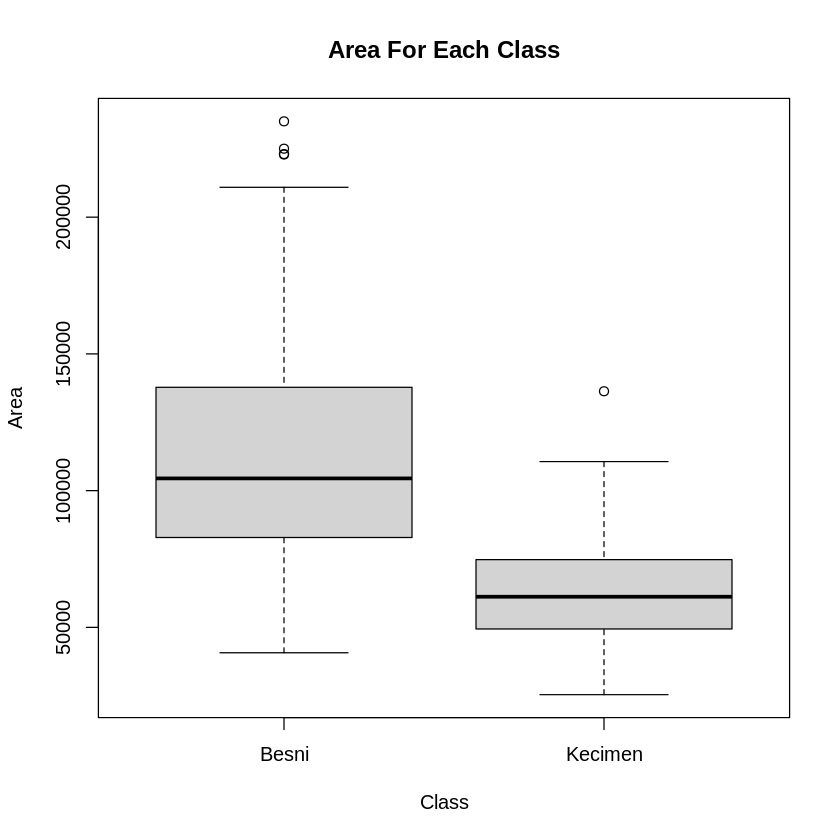

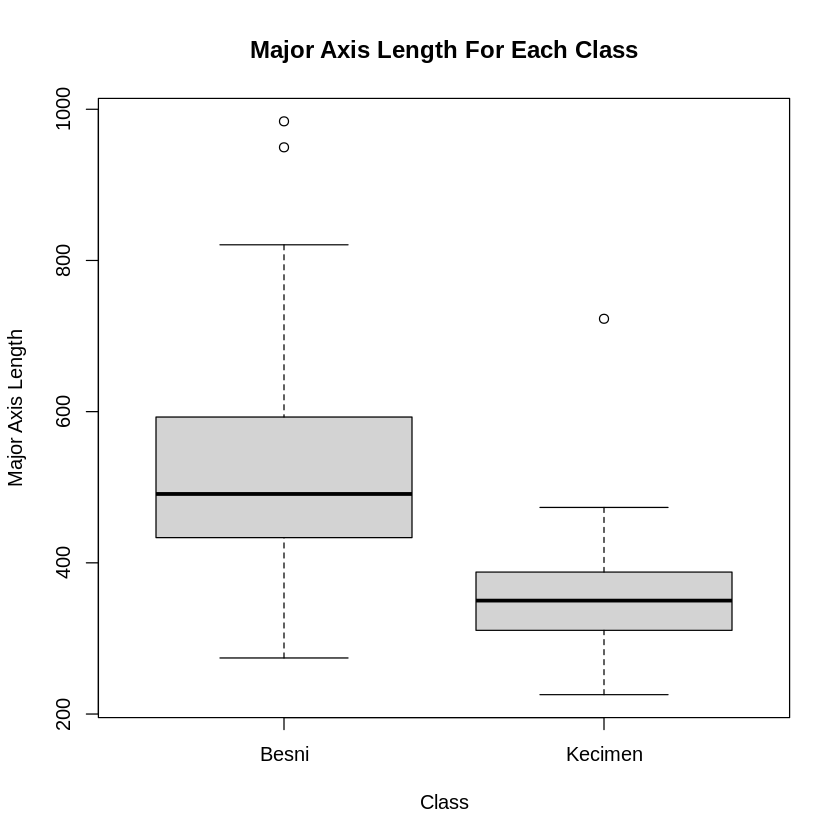

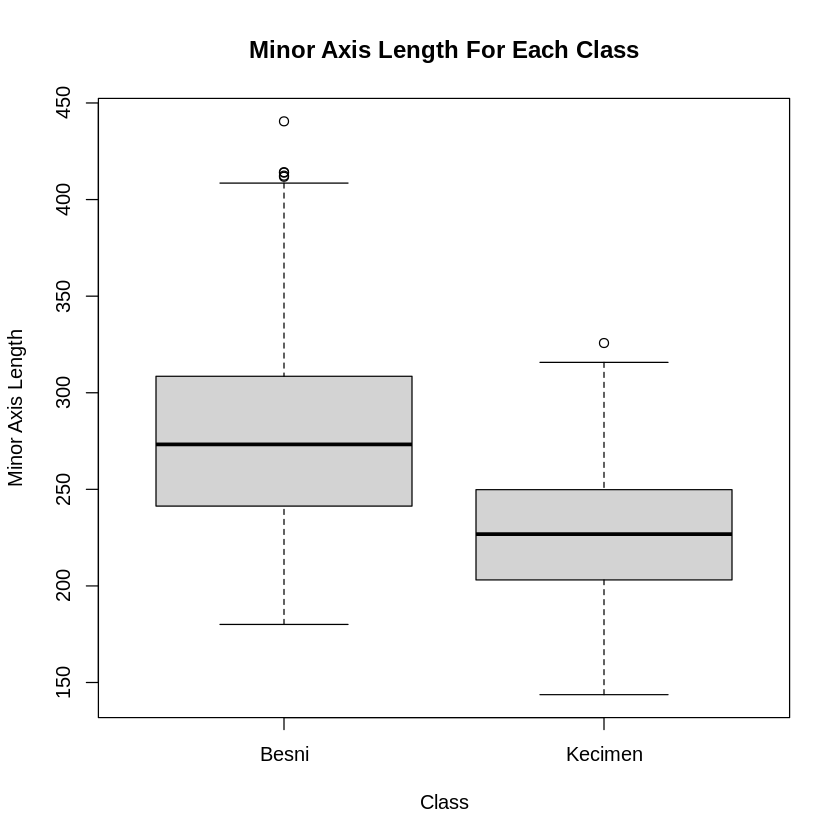

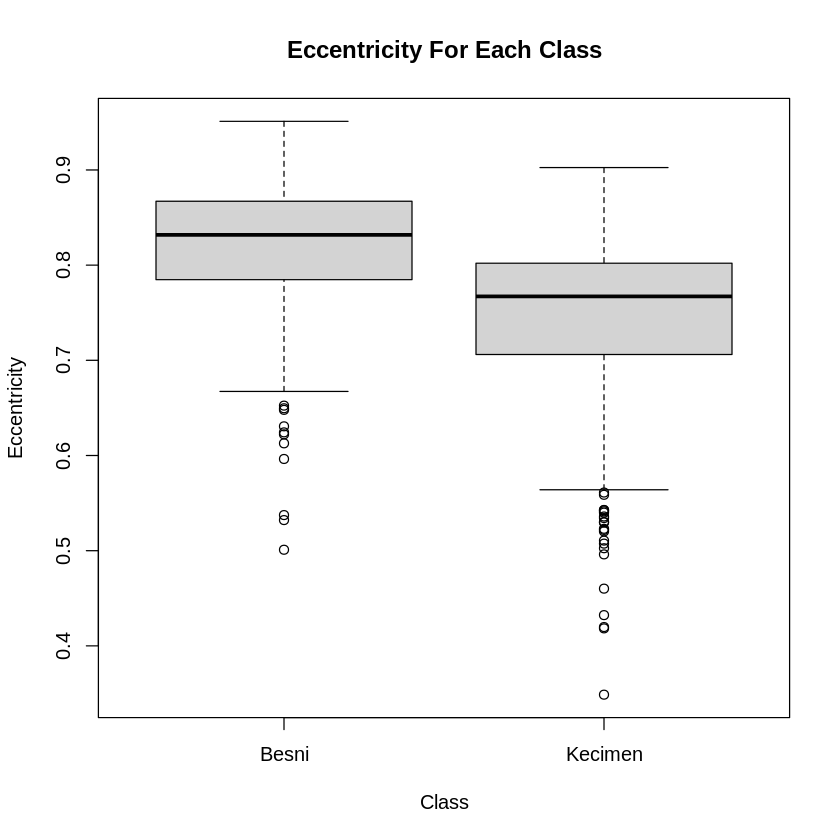

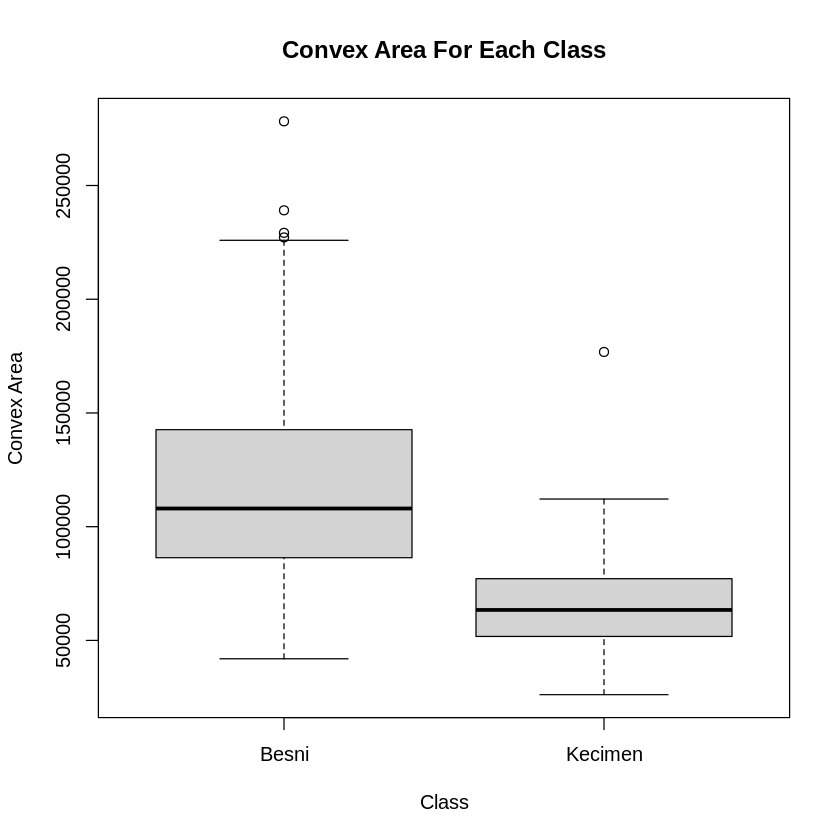

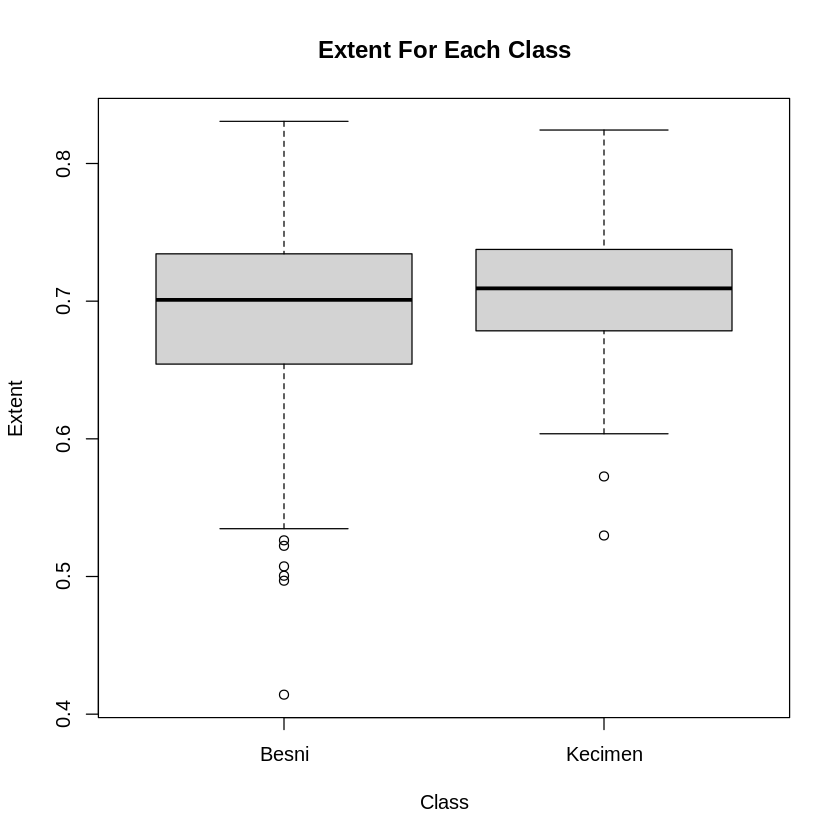

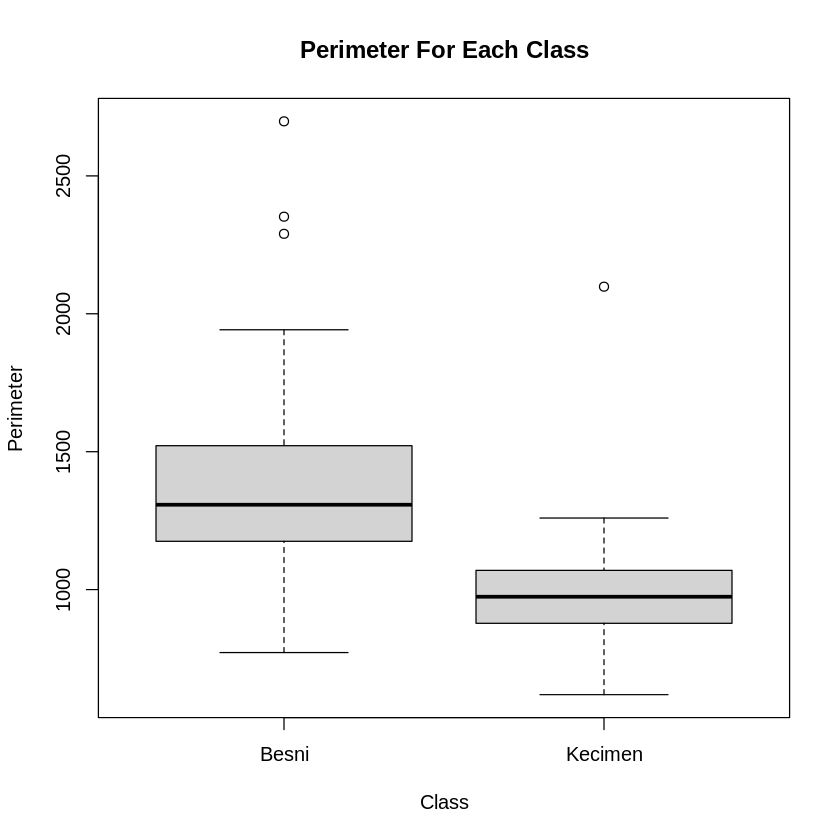

In [31]:
## Visualize the data using 7 boxplots: compare the distributions of every variable between two classes

## For each boxplot, if the distribution of that variable between two classes overlaps a lot, 
## that means this variable is not a good candidate of predictors. 
## The reason is that the two classes have similar values for this variable, so it's not able to 
## tell the class by just looking at that variable. Hence, we would only select variables that 
## don't have a lot of overlap in the boxplot to be our predictors.

## Below we are drawing the boxplots for every variable between the two classes.

area_boxplot <- boxplot(Area ~ Class, 
                        data = raisin_train, 
                        main = "Area For Each Class",
                        xlab = "Class",
                        ylab = "Area")
major_axis_length_boxplot <- boxplot(MajorAxisLength ~ Class, 
                        data = raisin_train, 
                        main = "Major Axis Length For Each Class",
                        xlab = "Class",
                        ylab = "Major Axis Length")
minor_axis_length_boxplot <- boxplot(MinorAxisLength ~ Class, 
                        data = raisin_train, 
                        main = "Minor Axis Length For Each Class",
                        xlab = "Class",
                        ylab = "Minor Axis Length")
eccentricity_boxplot <- boxplot(Eccentricity ~ Class, 
                        data = raisin_train, 
                        main = "Eccentricity For Each Class",
                        xlab = "Class",
                        ylab = "Eccentricity")
convex_area_boxplot <- boxplot(ConvexArea ~ Class, 
                        data = raisin_train, 
                        main = "Convex Area For Each Class",
                        xlab = "Class",
                        ylab = "Convex Area")
extent_boxplot <- boxplot(Extent ~ Class, 
                        data = raisin_train, 
                        main = "Extent For Each Class",
                        xlab = "Class",
                        ylab = "Extent")
perimeter_boxplot <- boxplot(Perimeter ~ Class, 
                        data = raisin_train, 
                        main = "Perimeter For Each Class",
                        xlab = "Class",
                        ylab = "Perimeter")

The boxplots above indicate that "Area" "MajorAxisLength" "MinorAxisLength" "ConvexArea" "Perimeter" are the variables that don't show much overlap for the two classes, so we will pick these five variables as our predictors.

## Methods:
To determine which variables are the best to predict a raisin variety, we first load our .csv dataset to our Juypter notebook and sketch a box plot. The box plot contains several (how many?) boxes and whiskers, showing the distribution of data points of each variables. Generating the plot allows us to compare the variables that show distinctive features of Kecimen and Besni varieties and then to choose the best 3 features to train our k-nn classification model. Next, we will find out which k-value to apply on our model by plotting a line graph of the k-value vs the accuracy. 
Work to be done
How many columns


## Expected outcomes and significance:
Upon completion of this analysis, we expect to be able to determine which combination of three variables out of the chosen five will give us the highest degree of accuracy when identifying the class of a raisin if presented with a raisin of either the Besni or Kecimen variety. By creating a successful classifier, we may be able to figure out which measurements of a raisin are the most significant. Likewise, we may be able to classify raisins of other varieties not included in the original study using the same predictive variables used in our classification model. With the completion of this project, one may wonder if there are other ways to classify these raisins. Is there a different way to classify between these two raisin varieties to the same degree of accuracy without using size and/or measurements of the raisin?